<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/6_Linear_twoclass_classification/6_3_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6: Linear two class classification

# Logistic Regression and the Softmax Cost

In the previous Section we saw how to derive logistic regression when employing label values $y_p \in \left\{0,+1\right\}$.  However as mentioned in the previous Section these label values are somewhat arbitrary, and one can just as easily derive logistic regression using label values $y_p \in \left\{-1,+1\right\}$.  In this Section we do just this, resulting in new cost function called the *Softmax cost* for logistic regression.  While the Softmax differs in form from the Cross Entropy cost, it is in fact equivalent to it (as we will show as well).  This means that - practically speaking - one can use either the Softmax or Cross Entropy in practice to achieve equivalent results.  However - in principle - the Softmax cost is far more valuable helps unify the diverse set of motivations for linear two-class classification (as we will see in the Sections that follow). 

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_6_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/6_Linear_twoclass_classification/chapter_6_datasets
else:
    print('chapter_6_datasets already cloned!')

# clone library subdirectory
if not Path('chapter_6_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/6_Linear_twoclass_classification/chapter_6_library
else:
    print('chapter_6_library already cloned!')

# clone images
if not Path('chapter_6_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/6_Linear_twoclass_classification/chapter_6_images
else:
    print('chapter_6_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_6_library')
sys.path.append('./chapter_6_datasets') 
sys.path.append('./chapter_6_images') 

# import section helper
import section_6_3_helpers

# dataset paths
data_path_1 = 'chapter_6_datasets/2d_classification_data_v1.csv'
data_path_2 = 'chapter_6_datasets/3d_classification_data_v0.csv'

# image paths
image_path_1 = 'chapter_6_images/Fig_4_10_new.png'
image_path_2 = 'chapter_6_images/Fig_4_11_new.png'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_6_datasets already cloned!
chapter_6_library already cloned!
chapter_6_images already cloned!


## Different labels, same story

If we change the label values from $y_{p}\in\left\{0,\,1\right\}$ to $y_{p}\in\left\{-1,\,+1\right\}$ much of the story we saw unfold in the previously Section unfolds here as well, with only slight differences.  That is, instead of our data ideally sitting on a step function (with linear boundary) with lower / upper steps taking on the values $0$ and $1$ respectively, they take on values $-1$ and $+1$ as shown below for prototypical cases where $N=1$ (left panel) and $N=2$ (right panel).

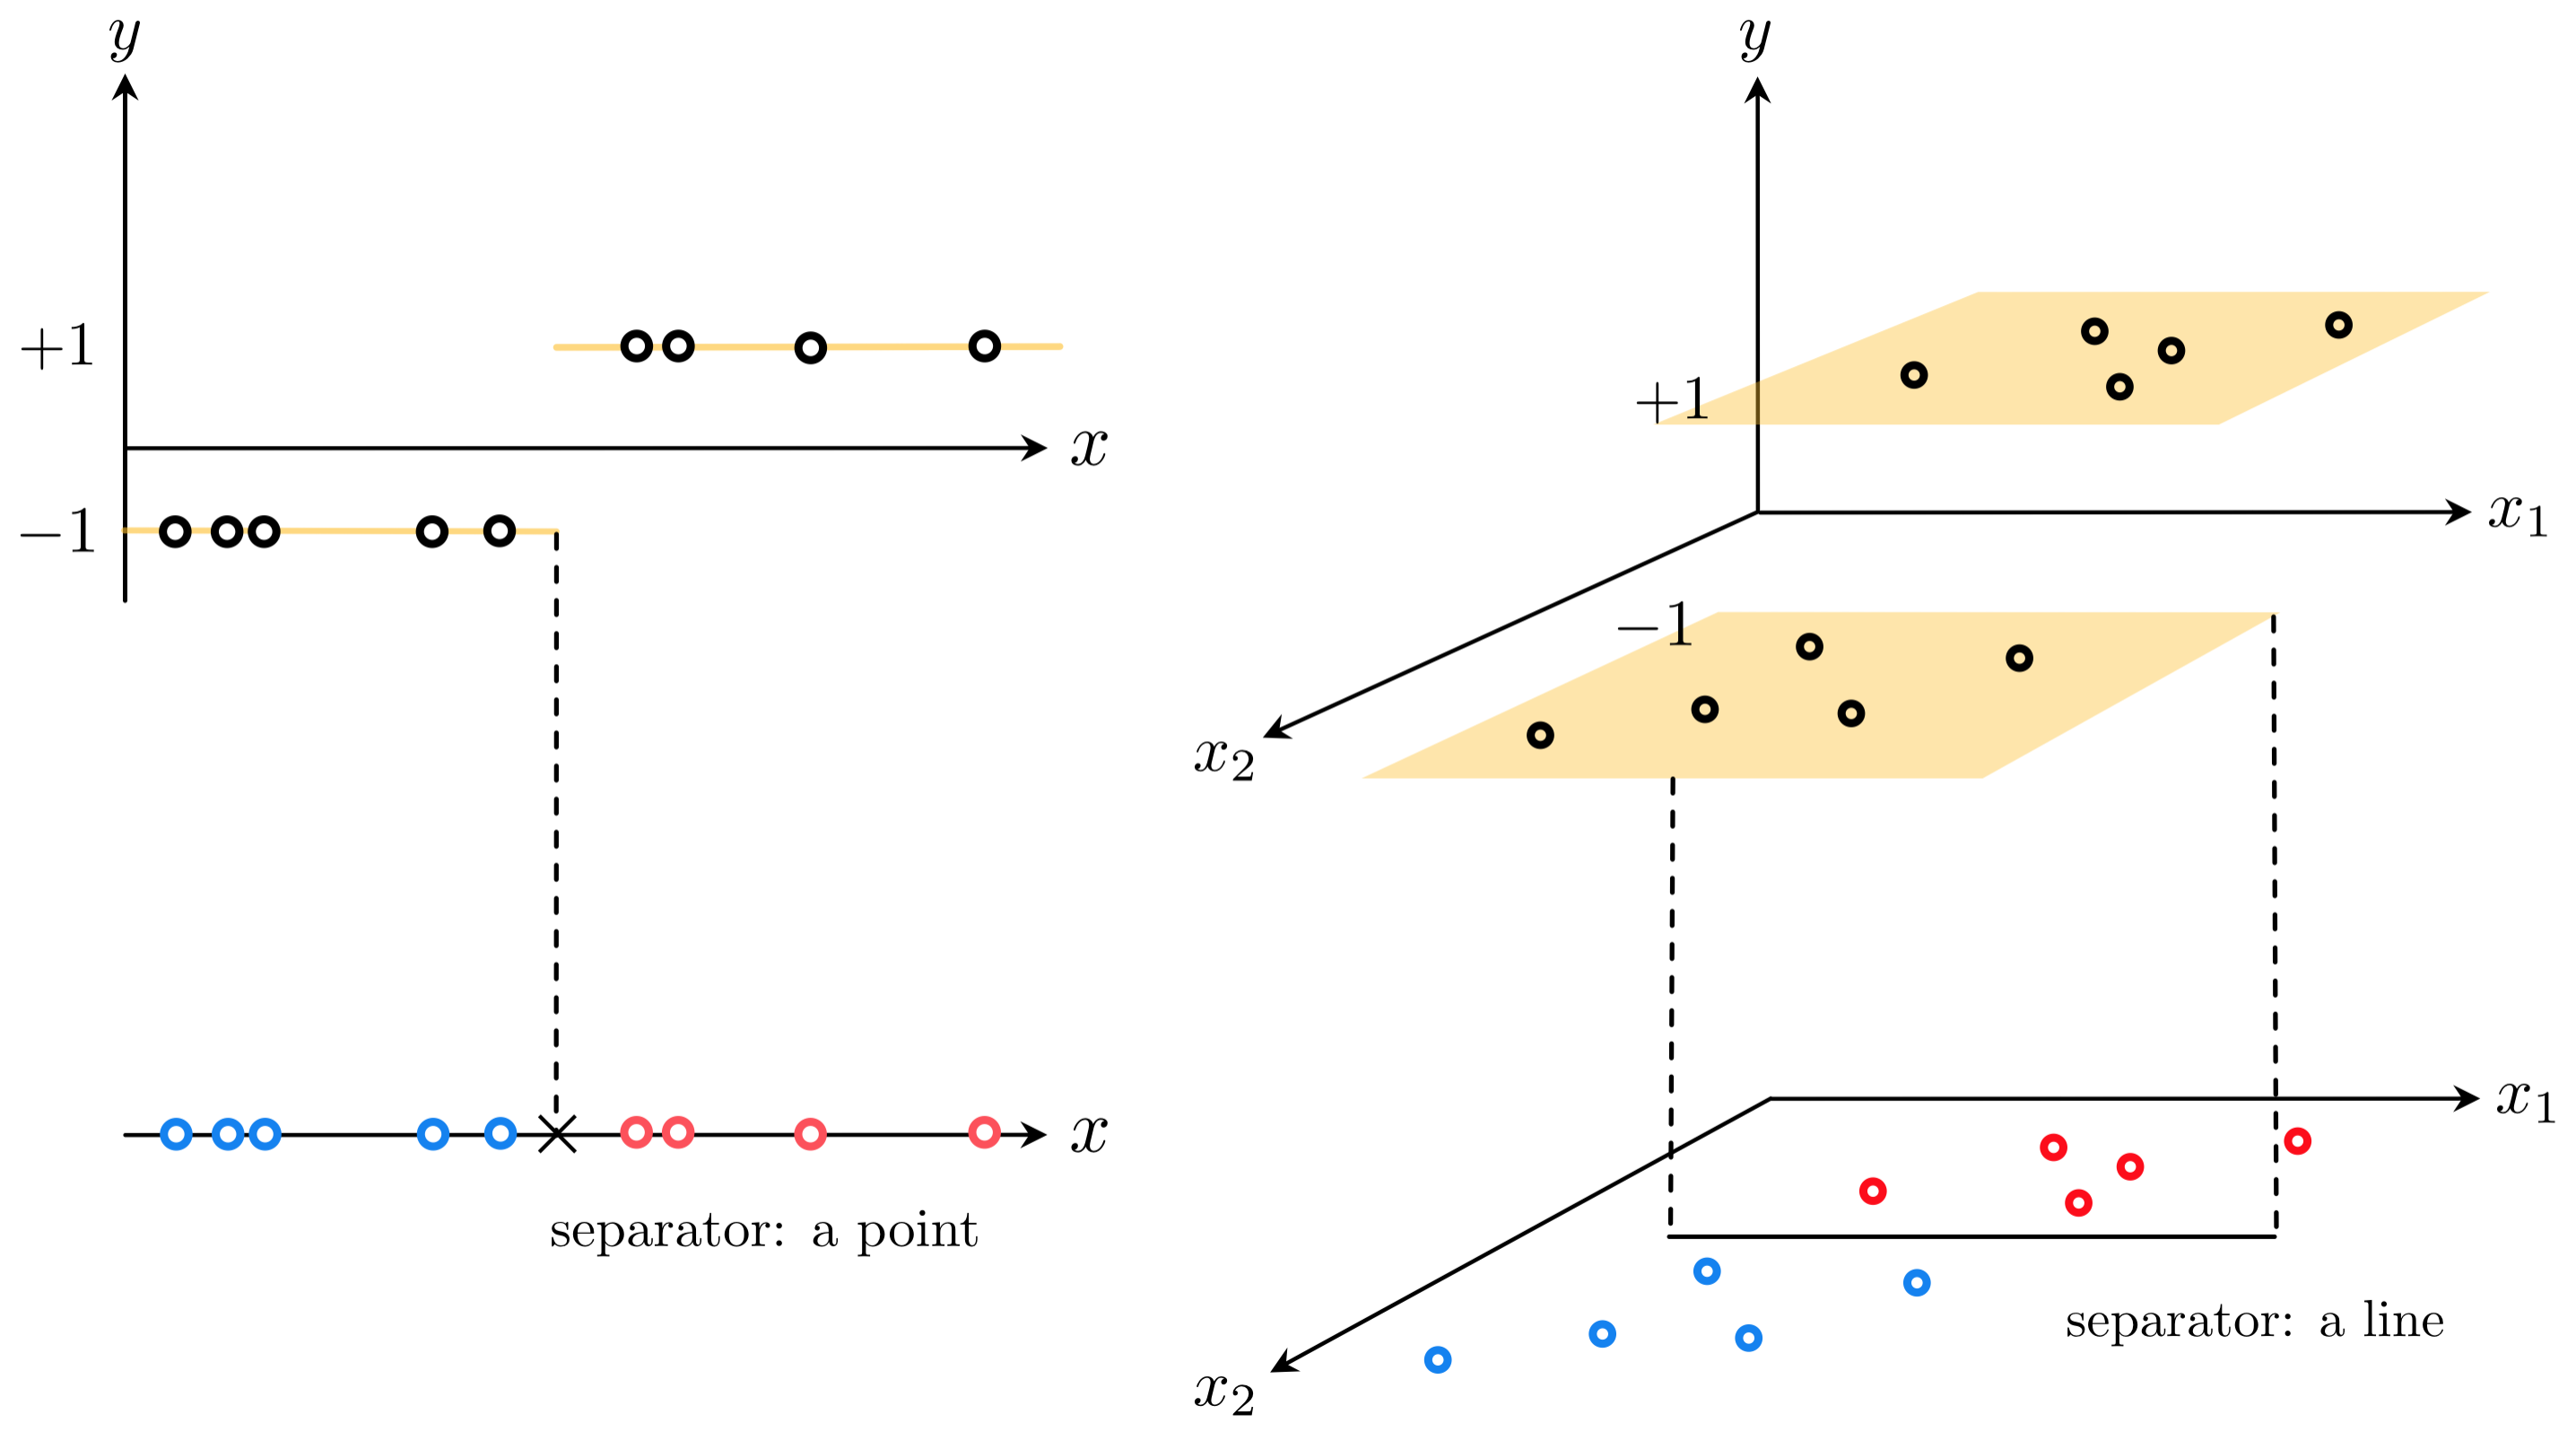

In [2]:
Image(image_path_1, width=800)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> Classification from a regression/surface-fitting perspective for single-input (left panels) and two-input (right panels) toy datasets. This surface-fitting view is equivalent to the perspective where we look at each respective dataset 'from above'.  In this perspective we can more easily identify the separating hyperplane, i.e., where the step function (shown here in yellow) transitions from its bottom to top step.  From this perspective the vertical axis (the actual $y$ value) is removed, with all points being represented by their input values only.  The label of each point is then represented by color: the points in blue denote label value $-1$ while those in red have label $+1$. </em>  </figcaption> 
</figure>

This step function taking on values $\left\{-1,+1\right\}$, having a *linear boundary between its bottom and top steps*, can be convinently written for general $N$ dimensional input as 

\begin{equation}
\text{sign}\left(\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,}\right)
\end{equation}


where we use our compact vector notation used in the previous Section and where the $\text{sign}\left(\cdot\right)$ function is defined as

\begin{equation}
\text{sign}(x) = 
\begin{cases}
+1 \,\,\,\,\,\text{if} \,\, x \geq 0 \\
-1 \,\,\,\,\,\text{if} \,\, x < 0 \\
\end{cases}.
\end{equation}

Notice in this case that our linear decision boundary - where this step function changes from the bottom to top step - lies along those $\mathring{\mathbf{x}}_{\,}^{T}$ where $\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,} = 0$.

As with data using labels $0$ and $1$  (see Example 1 in the previous Section), linear regression would in general provide poor performance for data of this sort.  Because we want to tune the weights of our model $\mathbf{w}$ so that our parameterized step function maps inputs to outputs correctly as

\begin{equation}
\text{sign}\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right) \approx y_p
\end{equation}

we could employ a Least Squares cost function involving $\text{sign}\left(\cdot\right)$ directly as 

\begin{equation}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P \left(\text{sign}\left(\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right) \right) - y_p \right)^2.
\end{equation}

However like the analagous Least Squares cost involving a step function in equation (4) of the previous Section, this too is discontinuous and completely flat everywhere.  Because we would need to *minimize* this cost in order to recover the ideal weights assumed in equation (3), and because we would do so using a local optimization scheme detailed in Chapters 2 - 4, this cost is useless for training purposes.

## The $\text{tanh}$ logistic sigmoid function

We could - as we did in the previous Section - then look to replace the discrete $\text{sign}\left(\cdot\right)$ with a *smooth approximation*.   A slightly re-scaled version of the *sigmoid* function - so that its values range between $-1$ and $1$ instead of $0$ and $1$ - serves this purpose well.  This scaled version of the sigmoid is often called the *hyperbolic tangent function* and is written as 

\begin{equation}
\text{tanh}(x) = 2\,\sigma\left(x\right) - 1 = \frac{2}{1 + e^{-x}} - 1.
\end{equation}

Given that the sigmoid function $\sigma\left(\cdot\right)$ ranges smoothly between $0$ and $1$, it is easy to see why $\text{tanh}\left(\cdot\right)$ as defined above ranges smoothly between $-1$ and $+1$.  In the figure below we plot the tanh function (left panel), as well as several internally weighted versions of it (right panel). As we can see in the figure, for the correct setting of internal weights the hyperbolic tangent function can be made to look arbitrarily similar to the sign function.

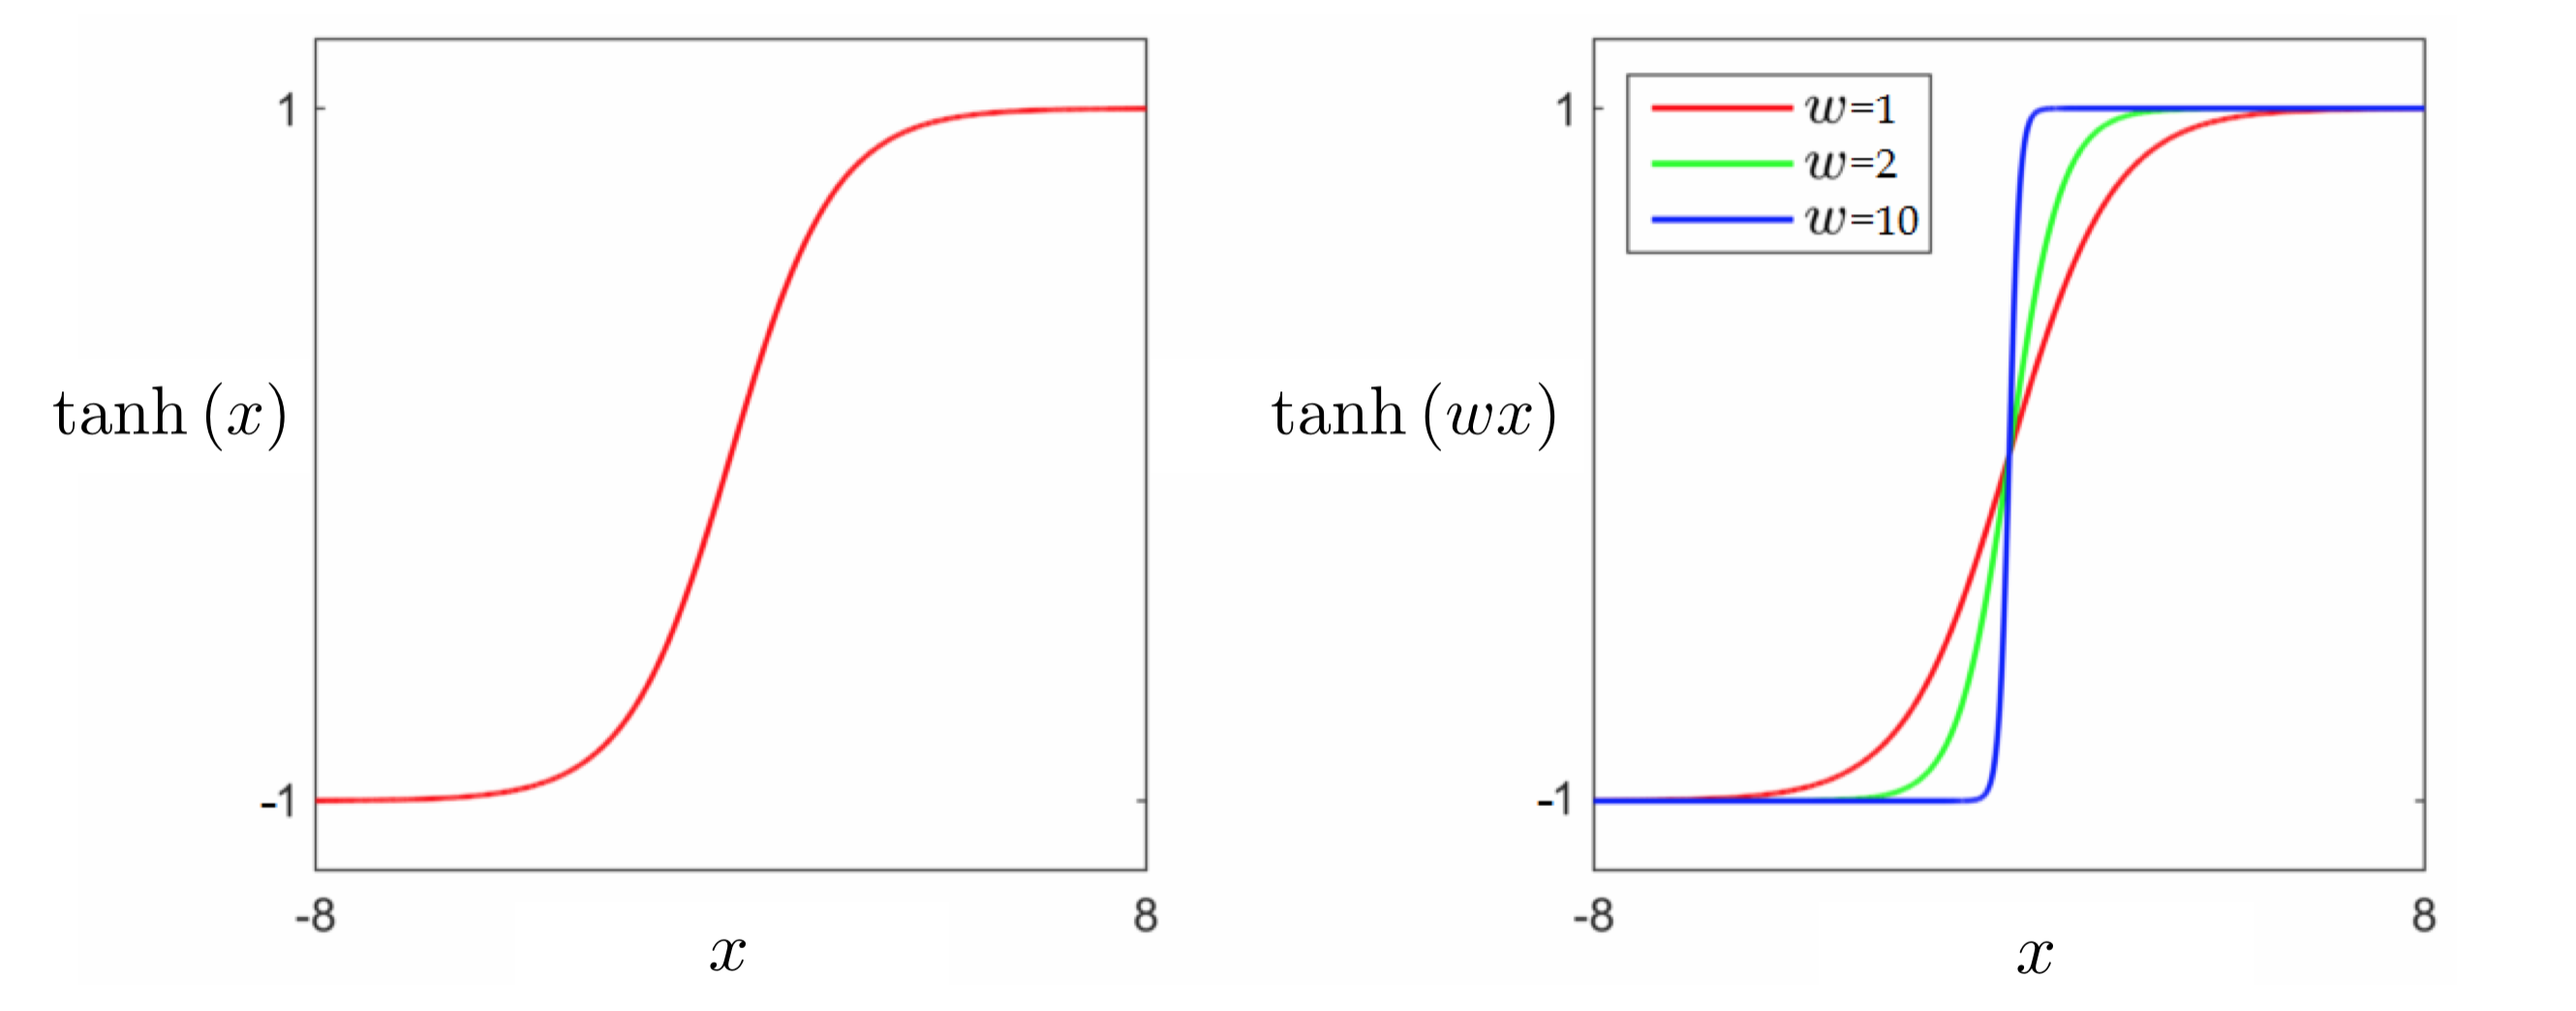

In [3]:
Image(image_path_2, width=800)

<figure>
  <figcaption>   
<strong>Figure 2:</strong> <em> (left panel) Plot of the hyperbolic tangent function $\text{tanh}(x)$. (right panel) By increasing the weight $w$ in $\text{tanh}(wx)$ from $w=1$ (shown in red) to $w=2$ (shown in green) and finally to $w=10$ (shown in blue), the internally weighted version of the tanh function becomes an increasingly
good approximator of the sign function. </em>  </figcaption> 
</figure>

## Logistic regression using the Least Squares cost

Replacing $\text{sign}\left(\cdot\right)$ with $\text{tanh}\left(\cdot\right)$ in equation (3) gives a similar desired relationship (assuming ideal weights are known)


\begin{equation}
\text{tanh}\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right) \approx y_p
\end{equation}

and analagous Least Squares cost function for recovering these weights

\begin{equation}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P \left(\text{tanh}\left(\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right) \right) - y_p \right)^2.
\end{equation}

However this Least Squares cost (visualized below) - like the one we saw in the prior Section - is non-convex and has large flat regions that can impair optimization progress.  

#### <span style="color:#a50e3e;">Example 1: </span> Visualizing various cost functions on a toy dataset

In the next Python cell we plot the Least Squares cost in equation (4) (left panel) for the dataset displayed in Example 1, over a wide range of values for $w_0$ and $w_1$.  This cost consists of discrete steps at many different levels, each one completely flat.  Because of this no local method can be used to minimize the counting cost.

In the middle and right panels we plot the surfaces of two related cost functions on the same dataset.  The middle plot shows the Least Squares cost in equation (7), and the right plot shows the corresponding *Softmax* cost introduced below.  

/Users/jeremywatt/Desktop/machine-learning-refined/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


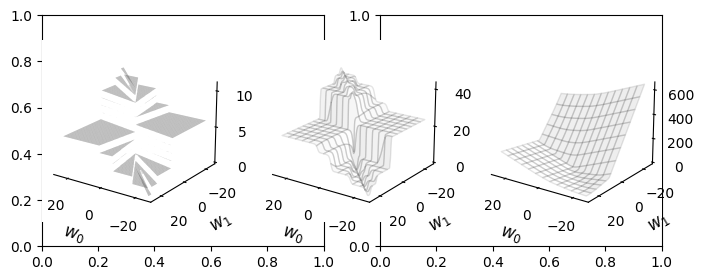

In [4]:
# load in dataset
data = np.loadtxt(data_path_1, delimiter = ',')

# create an instance of the visualizer and plot
demo2 = section_6_3_helpers.cost_visualizer(data)
demo2.plot_costs(viewmax = 25,view = [20,125])

##  Logistic regression using the Softmax cost

In complete analogy to the derivation of the cross-entropy cost in the previous Section, because our labels are constrained to take on values $y_p \in \left\{-1,+1\right\}$ here we can also construct a new cost function based on a penalty that more harshly penalizes error.  In particular, note that if we rearrange the hyperbolic tangent function in equation (5) terms of the sigmoid we have 

\begin{equation}
\sigma\left(x\right) = \frac{\text{tanh}(x) + 1}{2}.
\end{equation}

Studying this relationship we can note, in particular, that

\begin{equation}
\begin{array}
\
    \text{tanh}\left(x\right) \approx +1 \iff \sigma\left(x\right) \approx 1 \\
    \text{tanh}\left(x\right) \approx -1 \iff \sigma\left(x\right) \approx 0. \\
\end{array}
\end{equation}

Because of this relationship we can employ *the same point-wise cost function* - first detailed in the prior Section - called the *Log Error* only our current label values

\begin{equation}
g_{p}\left(\mathbf{w}\right)=
\begin{cases}
-\text{log}\left(\sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\,\,\,\,\,  \,\,\,\,  \text{if} \,\, y_p = +1 \\
-\text{log}\left(1 - \sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\text{if} \,\, y_p = -1. \\
\end{cases}
\end{equation}

This point-wise cost function is always nonnegative, and harshly penalizes classification errors.  In short with *ideal* weights $\mathbf{w}$ when $y_p = +1$ then $\text{tanh}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) \approx +1$ and the top condition gives $-\text{log}\left(\sigma\left( \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} \right)\right) \approx -\text{log}\left(1 \right) = 0$ and is very large otherwise.  Likewise when $y_p = -1$ with ideal weights $\text{tanh}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) \approx -1$ and the bottom case is likewise approximately $-\text{log}\left(1 \right) = 0$ (and severely punishes errors).

We can then form the *Softmax* cost for logistic regression by taking an average of these Log Error costs as 

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right). 
\end{equation}

As with the Cross Entropy cost it is far more common to express the Softmax cost differently by re-writing the Log Error in a equivalent way as follows.  First notice that because 

\begin{equation}
1 - \sigma\left(x\right) = 1 - \frac{1}{1 + e^{-x}} = \frac{1 + e^{-x}}{1 + e^{-x}} - \frac{1}{1 + e^{-x}} = \frac{e^{-x}}{1 + e^{-x}} = \frac{1}{1 + e^{x}} = \sigma(-x)
\end{equation}

that the second case in the point-wise cost above can be re-written equivalently as $-\text{log}\left(\sigma\left( - \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} \right)\right)$ and so the point-wise cost function can be written as

\begin{equation}
g_{p}\left(\mathbf{w}\right)=
\begin{cases}
-\text{log}\left(\sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\,\,\, \,  \text{if} \,\, y_p = +1 \\
-\text{log}\left(\sigma\left( -\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\text{if} \,\, y_p = -1. \\
\end{cases}
\end{equation}

Now notice that *because we are using the label values $\pm 1$* we can move the label value in each case *inside* the inner most paraenthesis, and we can write *both cases* in a single line as 

\begin{equation}
g_p\left(\mathbf{w}\right)=
-\text{log}\left(\sigma\left( y_p\,\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right).
\end{equation}

Finally since the negative log property states that $-\text{log}\left(x\right) = \frac{1}{x}$ we can re-write the point-wise cost above equivalently (using the definition of the sigmoid) as 

\begin{equation}
g_p\left(\mathbf{w}\right)=
\text{log}\left(1 + e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}\right)
\end{equation}

Taking the average of this point-wise cost over all $P$ points we have a more common appearance of the *Softmax cost for logistic regression*

\begin{equation}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}\right)
\end{equation}

This cost function, like the Cross Entropy cost detailed in the previous Section, is *always convex regardless of the dataset used*.  Moreover, as we can see here by its derivation, the Softmax and Cross Entropy cost functions are completely equivalent (upon change of label value $y_p = -1$ to $y_p = 0$ and vice-versa) having been built using the same point-wise cost function.  

##  Implementing and minimizing a modular Softmax cost in `Python`

We can implement the Softmax costs very similarly to the way we did the Least Sqwuares cost for linear regression, as detailed in the prior Section, breaking down our implementation into the linear `model` and the error itself.  Our linear `model` takes in both an appended input point $\mathring{\mathbf{x}}_p$ and a set of weights $\mathbf{w}$ 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = \mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}.
\end{equation}

With this notation for our model, the corresponding Softmax cost in equation (16) can be written

\begin{equation*}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p^{\,}\text{model}\left(\mathbf{x}_p,\mathbf{w}\right)}\right).
\end{equation*}

We can then implement the cost in chunks - first the `model` function below precisely as we did with linear regression.

In [5]:
# compute linear combination of input point
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

Note here that the *implementation* differs slightly from the algebraic form of the linear `model`, taking in the original input and forming the compact version (stacking a $1$ atop each input) once inside (as was first explained in [Section 5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html)).  

Using the Log Error costs we can then implement the Softmax - employing efficient and compact `numpy` operations - as 

In [6]:
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

# the convex cross-entropy cost function
def softmax(w):
    # compute sigmoid of model
    a = sigmoid(model(x,w))
    
    # compute cost of label 0 points
    ind = np.argwhere(y == -1)[:,1]
    cost = -np.sum(np.log(1 - a[:,ind]))
    
    # add cost on label 1 points
    ind = np.argwhere(y==+1)[:,1]
    cost -= np.sum(np.log(a[:,ind]))
    
    # compute cross-entropy
    return cost/y.size

Using the more compact and common expression for the Softmax cost, we can implement it equivalently as follows

In [7]:
# the convex softmax cost function
def softmax(w):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost/float(np.size(y))

The Softmax cost is *always convex* regardless of the dataset used - we will see this empirically in the examples below and a mathematical proof is provided in the appendix of this Section that verifies this claim more generally (one can also compute a conservative but provably convergent steplength parameter $\alpha$ for the Softmax cost based on its Lipschitz constant, which is also described in the appendix). We displayed a particular instance of the cost surface in the right panel of Example 2 for the dataset first shown in Example 1. Looking back at this surface plot we can see that it is indeed convex.

Since the Softmax cost function is convex a variety of local optimization schemes can be used to properly minimize it properly.  For these reasons the Softmax cost is used more often in practice for logistic regression than is the logistic Least Squares cost for linear classification.

> The Softmax cost is more widely used in practice for logistic regression than the logistic Least Squares cost. Being always convex we can use Newton's method to minimize the softmax cost, and we have the added confidence of knowing that local methods (gradient descent and Newton's method) are assured to converge to its global minima.

As alternative to using an Automatic Differentiator (which we use by default - employing `autograd` - see [Section 3.5](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_5_Automatic.html)), one can perform gradient descent here by hand-computing the gradient of the Softmax cost function.  Using the simple derivative rules outlined in Chapter 3 gradient can be computed as 

\begin{equation}
\nabla g\left(\mathbf{w}\right) = - \frac{1}{P}\sum_{p = 1}^P \frac{ e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,} }}{1 + e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}}\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{\,}
\end{equation}


Writing the gradient in this wah helps avoid numerical problems associated with using the exponential function on a modern computer. This is due to the exponential
'overflowing' with large exponents, e.g., $e^{1000}$, as these numbers are too large to store explicitly on the computer and so are
represented symbolically as $\infty$. This becomes a problem when evaluating $\frac{e^{1000}}{1+e^{1000}}$
which, although basically equal to the value $1$, is thought of by the computer to be a NaN (not a number) as it thinks $ $$\frac{e^{1000}}{1+e^{1000}}=\frac{\infty}{\infty}$
which is undefined. By writing each summand of the gradient such that it has an exponential in its denominator only, we avoid the problem
of dividing two overflowing exponentials.

In addition to employ Newton's method 'by hand' one can hand compute the Hessian of the Softmax function as

\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P \left( \frac{1}{1 + e^{\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}} \right)    \mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T.
\end{equation}

#### <span style="color:#a50e3e;">Example 2: </span> Using gradient descent to perform logistic regression using the Softmax cost

In this example we repeat the experiments of Example 2 of the previous Section - swapping out labels $y_p = 0$ with $y_p = -1$ - using the Softmax cost and gradient descent. 

In [8]:
# take input/output pairs from data
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = softmax; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 100; alpha_choice = 1;
weight_history,cost_history = section_6_3_helpers.gradient_descent(g,alpha_choice,max_its,w)

Below we show the result of running gradient descent with the same initial point and fixed steplength paarameter for $2000$ iterations, which results in a better fit.

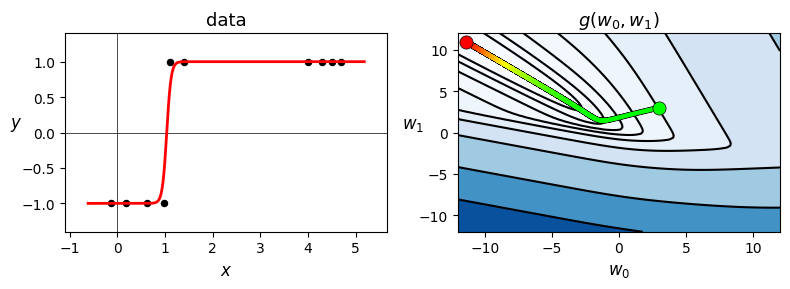

In [9]:
# run gradient descent to minimize the softmax cost
g = softmax; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 2000; alpha_choice = 1;
weight_history,cost_history = section_6_3_helpers.gradient_descent(g,alpha_choice,max_its,w)

# create a static figure illustrating gradient descent steps 
animator = section_6_3_helpers.classification_2d_visualizer(data,g)
animator.static_fig(weight_history,num_contours = 25,viewmax = 12)

##  "Noisy" datasets

Below we load in and plot a multi-input ($N = 2$) dataset that has 100 points, and whose two classes cannot be perfectly separated by any line (and consequently whose points cannot be perfectly fit using a tanh or even sign function).  In the left panel we show the data in three dimensions, and in the right panel we show the data as viewed 'from above', that is looking down from a point high up on the $y$ axis (or in other words, the data projected onto the plane $y = 0$).

/Users/jeremywatt/Desktop/machine-learning-refined/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  func(*args, **kwargs)


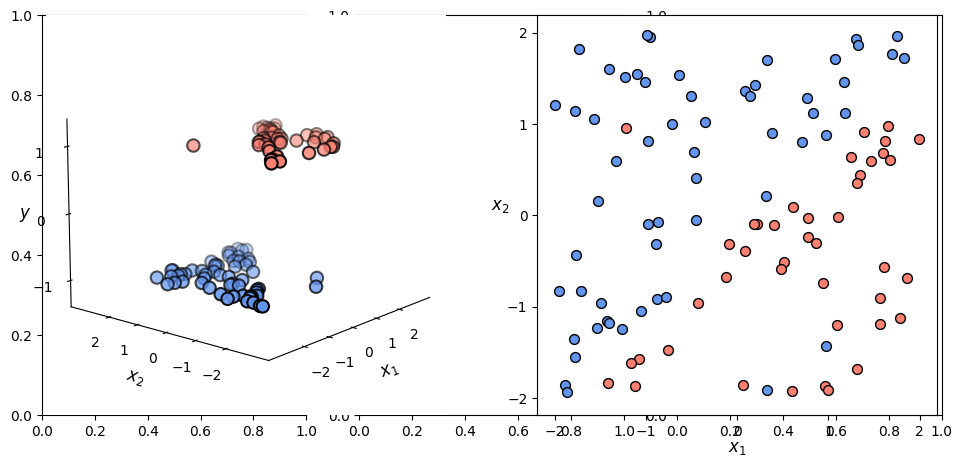

In [10]:
# load in dataset
data = np.loadtxt(data_path_2, delimiter = ',')

# create instance of linear regression demo, used below and in the next examples
demo = section_6_3_helpers.classification_3d_visualizer(data)

# plot data
demo.plot_data(view = [15,-140])

As you can see, there are three points here (two blue points and one red points) that look like they are on 'the wrong side'. Other than these 'noisy' points the two classes look like they can be very well fit with our nonlinear regressor $\text{tanh}\left(w_0 + w_1x_1 + w_2x_2\right)$ in the left panel and at the same time separated by the line $w_0 + w_1x_1 + w_2x_2 = 0$ in the right panel - provided the weights are tuned properly.  Note: in the classification context a 'noisy' point is one that has an incorrect label.  Such points are often *misclassified* by a trained classifier, meaning that their true label value will not be correctly predicted.  Two class classification datasets typically have noise of this kind and are not often perfectly separable by a hyperplane.  

Even with the presence of noise we can still find the best parameters of a linear decision boundary for a dataset like this by minimizing the Softmax cost.  In the next ``Python`` cell we run $100$ steps of gradient descent with a random initialization and fixed steplenth $\alpha = 1$ to minimize the Softmax cost on this dataset.

To ensure this is a proper steplength value we check the cost function history plot below.

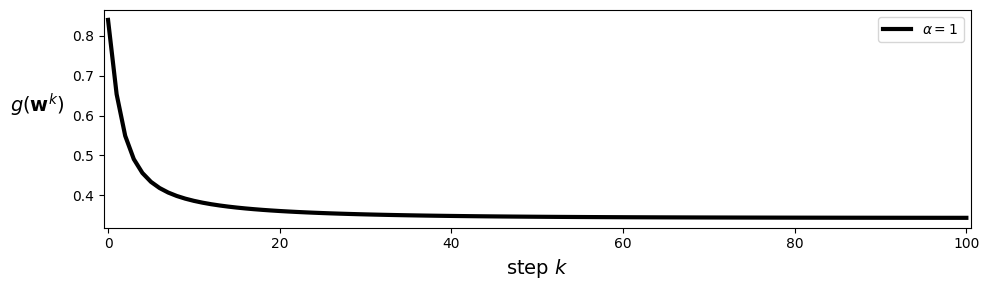

In [11]:
# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = softmax; w = np.random.randn(3,1); max_its = 100; alpha_choice = 1;
weight_history,cost_history = section_6_3_helpers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
section_6_3_helpers.static_visualizer().plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

In the next ``Python`` cell we plot the trained logistic function. In the left panel the dataset is shown in three dimensions, along with tanh surface fit. We also show draw the linear *decision boundary* in the plane $y = 0$.  This plane shows the linear decision boundary (where the tanh surface is zero) and is colored to indicate which of the input are determined to be of class $-1$ (the region of space colored light blue) and $+1$ (the region of space colored light red). In the right panel we plot the data, the decision boundary, and classified regions colored in the same way 'from above'.  Here we can easily identify three points that have been misclassified - our three 'on the wrong side' points (the two blue points in the red region, and the one red point in the blue region).

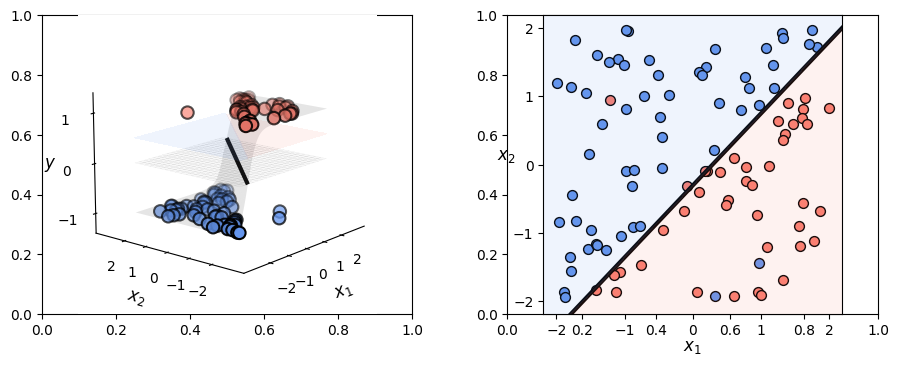

In [12]:
# create instance of 3d demos
demo = section_6_3_helpers.classification_3d_visualizer(data)

# draw the final results
demo.static_fig(weight_history[-1],view = [15,-140])

## Appendix

### Proof that the Softmax cost function is convex

To show that the Softmax cost function is convex we can use the second order definition of convexity, by which we must show that the eigenvalues of the Softmax's Hessian matrix are all always nonnegative. Studying the Hessian of the Softmax - which was defined algebraically in Example 4 above - we have 

\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P \left( \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T{\mathbf{w}_{\,}^{\,}}}} \right)    \, \mathbf{x}_p^{\,}\mathbf{x}_p^T.
\end{equation}

We know that the smallest eigenvalue of any square symmetric matrix is given as the minimum of the *Rayleigh quotient* (as detailed [Section 3.2](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_2_First.html)), i.e., the smallest value taken by 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}
\end{equation}

for any unit-length vector $\mathbf{z}$ and any possible weight vector $\mathbf{w}$. Substituting in the particular form of the Hessian here, denoting $\sigma_p = \left( \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T{\mathbf{w}_{\,}^{\,}}}} \right) $ for each $p$ for 
short, we have

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}=
\mathbf{z}^T \left(\frac{1}{P} \sum_{p=1}^{P}\sigma_p \mathbf{x}_p^{\,}\mathbf{x}_p^T\right) \mathbf{z}^{\,} =  \frac{1}{P}\sum_{p=1}^{P}\sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)\left( \mathbf{x}_{p}^T \mathbf{z}^{\,} \right) = \frac{1}{P}\sum_{p=1}^{P} \sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2
\end{equation}

Since it is always the case that $\left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2 \geq 0$ and $\sigma_p \geq 0$, it follows that the smallest value the above can take is $0$, meaning that this is the smallest possible eigenvalue of the Softmax cost's Hessian.  Since this is the case, the Softmax cost must be convex.

### Computation of the Lipschitz constant 

Building on the analysis above showing that the Softmax cost is convex, we can likewise compute its largest possible eigenvalue by noting that the largest value $\sigma_k$ (defined previously) can take is $\frac{1}{4}$

\begin{equation}
\sigma_k \leq \frac{1}{4}
\end{equation}

Thus the largest value the *Rayleigh quotient* can take is bounded above for any $\mathbf{z}$ as 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,} \leq \frac{1}{4P}\mathbf{z}^T \left(\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}
\end{equation}

Since the maximum value $\mathbf{z}^T \left(\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}$ can take is the maximum eigenvalue of the matrix $\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T $, thus a Lipschitz constant for the Softmax cost is given as

\begin{equation}
L = \frac{1}{4P}\left\Vert \sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T \right\Vert_2^2
\end{equation}